# This notebook uses pytorch lightning & optuna & an LSTM

This notebook trains an LSTM on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl
import optuna
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
# from src.plot import plot_from_loader
from src.models.lstm import SequenceDfDataSet, LSTM_PL, plot_from_loader
from src.dict_logger import DictLogger

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

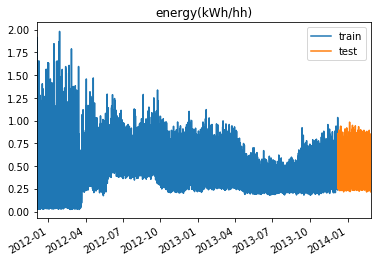

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Hyperparam search

In [8]:
PERCENT_TEST_EXAMPLES = 0.3
EPOCHS = 2
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'lstm'
name = "lstm1"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [9]:
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/lstm


In [10]:
def main(trial, train=True):
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode='min')

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name=name, version=trial.number)
#     print("log_dir", logger.experiment.log_dir)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LSTM_PL(trial.params)
    if train:
        trainer.fit(model)
    return model, trainer

In [44]:
def add_suggest(trial):
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    trial.suggest_uniform("lstm_dropout", 0, 0.75)
    trial.suggest_categorical("hidden_size", [1, 2, 4, 8, 16, 32, 64, 128])    
    trial.suggest_categorical("lstm_layers", [1, 2, 4, 8])    
    trial.suggest_categorical("bidirectional", [False, True])    
    
    # constants
    trial.suggest_int("window_length", 24 * 2, 24 * 2)
    trial.suggest_int("target_length", 24, 24)
    trial.suggest_int("max_nb_epochs", 20, 20)
    trial.suggest_int("num_workers", 4, 4)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("vis_i", 670, 670)
    trial.suggest_int("input_size", 17, 17)
    trial.suggest_int("batch_size", 16, 16)    
    return trial

In [45]:

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    trial = add_suggest(trial)

    
    print('trial', trial.number, 'params', trial.params)
    
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, logger.metrics[-1])
    model.logger.save()
    
    return model.logger.metrics[-1]['val_loss']


In [12]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name='no-name-b60e37fc-4ab6-4793-8a0a-c87a1b40c5c0', load_if_exists=True)

# shutil.rmtree(MODEL_DIR)

[I 2020-02-01 20:52:09,183] Using an existing study with name 'no-name-b60e37fc-4ab6-4793-8a0a-c87a1b40c5c0' instead of creating a new one.


In [13]:
study.optimize(objective, n_trials=200, timeout=6000)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


trial 10 params {'batch_size': 16, 'bidirectional': False, 'grad_clip': 40, 'hidden_size': 64, 'input_size': 17, 'learning_rate': 0.00010639577108177795, 'lstm_dropout': 0.5343276200876307, 'lstm_layers': 4, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': 670, 'window_length': 48}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0


KeyboardInterrupt: 

In [ ]:
study.optimize(objective, n_trials=200, timeout=6000)

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

# Test

[I 2020-01-29 08:42:54,398] Finished trial#8 resulted in value: 0.005635036621242762. Current best value is 0.005635036621242762 with parameters: {'batch_size': 16, 'bidirectional': False, 'grad_clip': 40, 'hidden_size': 128, 'input_size': 17, 'learning_rate': 0.00019134834148401144, 'lstm_dropout': 0.4080689425353674, 'lstm_layers': 8, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': 670, 'window_length': 48}.

In [14]:
try:
    trial = study.best_trial
except ValueError as e:
    logging.warning(f"Could not load best trial as: '{e}'")
    trial = study.get_trials(1)[0]
trial

FrozenTrial(number=8, value=0.005635036621242762, datetime_start=datetime.datetime(2020, 1, 29, 7, 59, 34, 718923), datetime_complete=datetime.datetime(2020, 1, 29, 8, 42, 54, 291152), params={'batch_size': 16, 'bidirectional': False, 'grad_clip': 40, 'hidden_size': 128, 'input_size': 17, 'learning_rate': 0.00019134834148401144, 'lstm_dropout': 0.4080689425353674, 'lstm_layers': 8, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': 670, 'window_length': 48}, distributions={'batch_size': IntUniformDistribution(high=16, low=16), 'bidirectional': CategoricalDistribution(choices=(False, True)), 'grad_clip': IntUniformDistribution(high=40, low=40), 'hidden_size': CategoricalDistribution(choices=(1, 2, 4, 8, 16, 32, 64, 128)), 'input_size': IntUniformDistribution(high=17, low=17), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-05), 'lstm_dropout': UniformDistribution(high=0.75, low=0), 'lstm_layers': CategoricalDistribution(choices=(1, 2, 4, 8)), 'max_nb_epochs':

In [48]:
trial = optuna.trial.FixedTrial(params={'number':45, 'batch_size': 16, 'bidirectional': False, 'grad_clip': 40, 'hidden_size': 128, 'input_size': 17, 'learning_rate': 0.00019134834148401144, 'lstm_dropout': 0.4080689425353674, 'lstm_layers': 8, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': 670, 'window_length': 48})
trial = add_suggest(trial)
trial.number = 103
main(trial)

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
            Name     Type Params
0         _model  LSTMNet    1 M
1   _model.lstm1     LSTM  999 K
2  _model.linear   Linear    1 K



step 0, {'val_loss': '0.23856914043426514'}


KeyboardInterrupt: 

In [ ]:
# model, trainer = main(trial, train=True)

In [ ]:
# model, trainer = main(trial, train=False)

In [ ]:
# plot
loader = model.val_dataloader()[0]
vis_i=640
plot_from_loader(loader, model, vis_i=vis_i, n=5)
plt.show()

In [ ]:
# test
trainer.test(model)